# Mask R-CNN for detecting car damage

### Table of content

1. Use case description
2. Data
3. Model
4. Training
5. Accuracy
6. Results

### Use case description

Mask R-CNN is an instance segmentation where each individual object is separated and identified; this approach incldues finding the bounding boxes of each object and assignment of the unique label to the identified objects [1]. The model is trained on COCO dataset which is a large-scale object detection, segmentation, and captioning dataset including 80 categories, 1,500,000 object instances, and over 330,000 images [2]. 

The goal of this notebook is to explore the Mask R-CNN model to detect car damage areas. The underlying rationale for this model development resides in its potential utility within the insurance industry, wherein expedited claims processing can be facilitated through the integration of user-uploaded images, thereby enabling damage assessment. Additionally, the model exhibits relevance to financial institutions, particularly when engaged in the underwriting of automotive loans, with a specific focus on pre-owned vehicles.

##### Set up the environment

Import all the necessary packages and set the plotting preferences.

In [1]:
from mrcnn import utils, visualize

import os
import json
import numpy as np
from PIL import Image

import skimage

from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

### Data

The dataset was retrived from Matterport Mask R-CNN repository which is highly recommended to use by the original author. This sample consists of 66 images, 50 of which are in the train set and 16 in the validation. Each image was further annotated using VGG Image Annotator tool (v 1.0.6) that lets us create custom annotations for any dataset. 

The dataset's location is stored in Priya Dwivedi's GitHub repository and was retrieved using (download-directory)[https://download-directory.github.io/] website to retrieve a subdirectory storing the images and annotations. 

Random image: customImages/train/image2.jpg


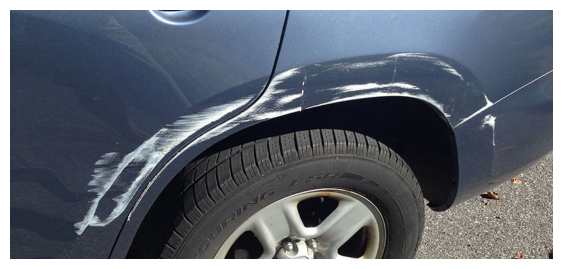

In [2]:
# show an example of image 

# select a random image
img = 'customImages/train/' + np.random.choice(os.listdir('customImages/train'), 1)[0]

# print selection
print(f'Random image: {img}')

# plot image
plt.figure(figsize=(7, 4))      # set figure size
plt.imshow(Image.open(img))     # show image
plt.axis('off')                 # remove axis
plt.grid(False)                 # remove grid
plt.show()                      # show image

#### Load data 

We will use the predefined functionality given by the (Mask R-CNN)[https://github.com/matterport/Mask_RCNN] repository. Specifically, we will use their data loading class - `Dataset` from the `utils` file. 

In [3]:
# load images and annotations
class CustomDataset(utils.Dataset):
    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("damage", 1, "damage")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations1.values()) # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()]

            # load_mask() needs the image size to convert polygons to masks.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
            "damage", ## for a single class just add the name here
            image_id=a['filename'], # use file name as a unique image id
            path=image_path,
            width=width, height=height,
            polygons=polygons)

In [4]:
import custom 

# Root directory of the project
ROOT_DIR = os.getcwd()

config = custom.CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "customImages")
print(CUSTOM_DIR)


# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = custom.CustomDataset()
dataset.load_custom(CUSTOM_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

c:\Users\dinar\Desktop\university\computer_vision\rcnn_car_damage\customImages
Image Count: 49
Class Count: 2
  0. BG                                                
  1. damage                                            


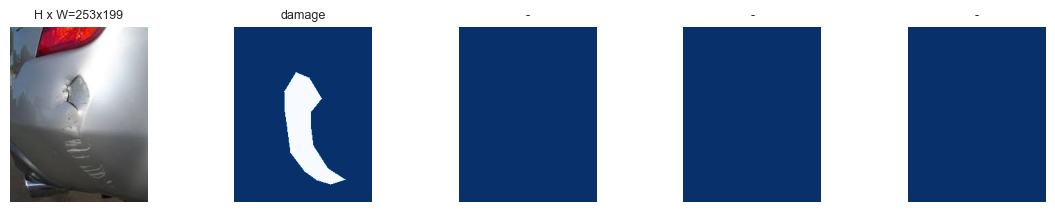

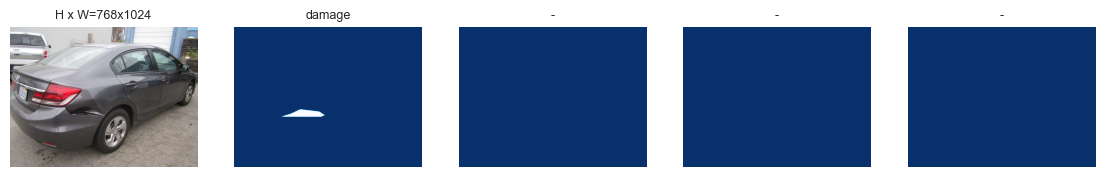

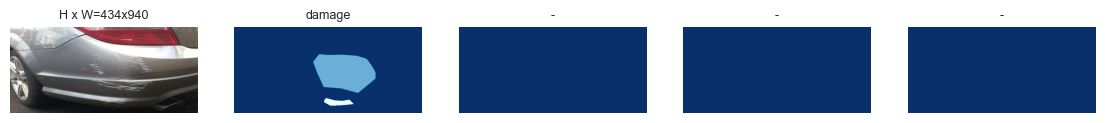

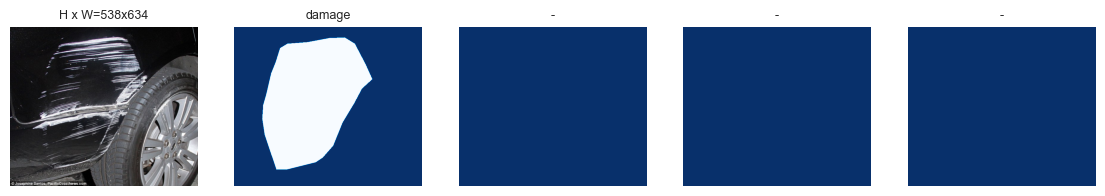

In [5]:
# display images
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

#### References

[1] He, K., Gkioxari, G., Dollár, P., & Girshick, R. (2017). Mask r-cnn. In *Proceedings of the IEEE international conference on computer vision* (pp. 2961-2969).

[2] Lin, T. Y., Maire, M., Belongie, S., Hays, J., Perona, P., Ramanan, D., ... & Zitnick, C. L. (2014). Microsoft coco: Common objects in context. In *Computer Vision–ECCV 2014: 13th European Conference, Zurich, Switzerland, September 6-12, 2014, Proceedings, Part V 13* (pp. 740-755). Springer International Publishing.